In [1]:
# utilities
import pandas as pd
import jsonlines
import json
import pickle
import numpy as np
from csv import DictReader

# model training
#for binary classification
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import svm
#for hyperparams tuning
from sklearn.model_selection import RandomizedSearchCV
#for the confusion matrix
from sklearn import metrics

#visualization 
import seaborn as sns
import matplotlib.pyplot as plt

Firstly convert the jsonl files into dataframe and save it into .csv file

In [ ]:
#DEV SET OK
df = pd.read_json(r'emb_dev.jsonl')
export_csv = df.to_csv(r'emb_dev.csv', index = None, header=True)

In [ ]:
# TEST SET OK
df1 = pd.read_json(r'emb_test.jsonl')
export_csv = df1.to_csv(r'emb_test.csv', index = None, header=True)

In [ ]:
#TRAIN SET OK
df2 = pd.read_json(r'emb_train.jsonl')
export_csv = df2.to_csv(r'emb_train.csv', index = None, header=True)

In [ ]:
# EXPORTING THE .CSV OF THE TRAIN SET
from google.colab import files
files.download("emb_train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**TEST OF EVERYTHIN WITH SMALL DATA**

In [2]:
#load the data
dev_df = pd.read_csv('emb_dev.csv')#,nrows=100)

In [3]:
test_df = pd.read_csv('emb_test.csv')#,nrows=100)

In [4]:
train_df = pd.read_csv('emb_train.csv')#,nrows=100)

In [5]:
''' Method to modify the dataset taking only the usefull fields 'output' and 'claim_embedding' and convert the output's values into binary values for the classification
  Input: dataframe to modify
  Output: modified dataframe
'''
def modify_df(df):  
    #delete the useless columns
    del df['id']
    del df['input']

    dict_output = {}
    list_values = []
    #extract the items from the output column
    output = df['output']
    for item in output:
        #to convert the string of dict into dict
        dict_output= eval(item)
        # change values to represent labels as 0 ("REFUTES") and 1 ("SUPPORTS") and add them to a list
        for i in dict_output:
            if (dict_output[i] == 'REFUTES'):
                list_values.append(0)
            else:
                list_values.append(1)

    #create a new column of the df with the list of zeros and ones 
    df['labels'] = list_values
    #delete the output column
    del df['output']
    return df 

In [6]:
# obtain the dataset processed 
dev = modify_df(dev_df)

In [15]:
dev.head()

,claim_embedding,labels
0,"[0.0312394015491, -0.19459494948387102, -0.207...",1
1,"[0.0312394015491, -0.19459494948387102, -0.207...",0
2,"[0.0312394015491, -0.19459494948387102, -0.207...",0
3,"[0.0312394015491, -0.19459494948387102, -0.207...",1
4,"[0.0312394015491, -0.19459494948387102, -0.207...",1


In [7]:
# obtain the dataset processed 
train = modify_df(train_df)

In [17]:
train.head()

,claim_embedding,labels
0,"[-0.23010256886482203, 0.021919053047895, -0.0...",1
1,"[-0.23010256886482203, 0.021919053047895, -0.0...",1
2,"[-0.23010256886482203, 0.021919053047895, -0.0...",1
3,"[-0.23010256886482203, 0.021919053047895, -0.0...",0
4,"[-0.23010256886482203, 0.021919053047895, -0.0...",1


#### For training the classification model, firstly we split the datasets:
- train_set divided in:
    - x_train (embeddings vectors)  
    - y_train (label) 
- dev_set divided in:
    - x_dev (embeddings vectors), 
    - y_dev (label)
- test_set becames x_test (embeddings vectors)

In [8]:
x_train_emb = train['claim_embedding']
#convert string to list 
x_train = [n.strip('][').split(', ') for n in x_train_emb]

y_train = train.labels

In [9]:
x_dev_emb = dev['claim_embedding']
#convert string to list 
x_dev = [n.strip('][').split(', ') for n in x_dev_emb]

y_dev = dev.labels

In [10]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

# KNN Classifier 
--------------------------------------------------------------------------------------

### Tuning on the dev set
Function for tuning the hyperparameters. It returns the best params to use for the KNN

In [21]:
''' Method for tuning the hyperparameters
  Input: splitted dev set into x and y for the fit of the RandomizedSearchCV
  Output: best params to use for the KNN
'''
def tuning(x_dev,y_dev):
    # define the parameter values that should be searched
    k_range = list(range(1,30,4))
    weight_options = ['uniform', 'distance'] # distance: more weight to more similar values
    algo_options = ['auto', 'ball_tree', 'kd_tree', 'brute']
    distance_options = [1,2,3] # different types of distances (manhattan, euclidean, minkowksi)
    
    # save the "parameter grid"
    param_grid = dict(n_neighbors=k_range, weights=weight_options, algorithm =algo_options,  p=distance_options)
    print('Params grid: ',param_grid) #need this for the report

    #define the classification model chosen
    model = KNeighborsClassifier()
    rand = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=5, n_jobs=-1)
    rand.fit(x_dev, y_dev)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    #save the optimize parameters
    best_param = rand.best_params_
    #return the tuning params for the model
    return best_param 

#### Now using the best parameter obtained by the tuning with the RandomizedSearchCV, we can train the train_set with the KNN

In [22]:
params = tuning(x_dev,y_dev) #dict of best parameters for the classifier

Params grid:  {'n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2, 3]}


c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Rand. Best Score:  0.5028724627633527


In [23]:
params

{'weights': 'uniform', 'p': 1, 'n_neighbors': 29, 'algorithm': 'kd_tree'}

TRAIN THE MODEL AND SAVE IT

In [25]:
''' Method for training the model using the KNeighborsClassifier() as binary classifier. After the training, the model is saved into a pickle file
  Input: dictionary of the tuned parameters, train set splitted in feature and target (x_train, y_train)
'''
def classifier(params, x_train, y_train):
    #train the model using the optimized params obtained in the tuning
    knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'], weights=params['weights'], algorithm= params['algorithm'], p=params['p'])
    
    #fit the model
    knn.fit(x_train, y_train)
    
    # save the model to disk
    filename = 'KNN.sav'
    pickle.dump(knn, open(filename, 'wb'))

In [26]:
classifier(params, x_train, y_train)

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


MAKE CLASS PREDICTION ON  THE SAVED MODEL 

In [ ]:
# load the trained model from disk
knn = pickle.load(open('KNN.sav', 'rb'))

In [12]:
# make class predictions for the dev set, we need this to evaluate the model
y_pred_class = knn.predict(x_dev)

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


EVALUATE THE MODEL

In [15]:
''' Function for the evaluation of the model. Using the metrics function from the library sklearn, here we compute the accuracy_score, the confusion_matrix and the precision and recall of the targets 'SUPPORTS', 'REFUTES'.
  Input: y_dev, predicted class
  Output: accuracy score,confusion matrix,precision score,recall score
'''
def evaluation(y_dev,y_pred_class):    
    # compute the accuracy 
    accuracy = metrics.accuracy_score(y_dev, y_pred_class)
    
    #build the confusion matrix and plot it
    confusion = metrics.confusion_matrix(y_dev, y_pred_class)
                #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # compute the precision and the recall on the label and print them
    target_names = ['SUPPORTS', 'REFUTES']
    print(metrics.classification_report(y_dev, y_pred_class, target_names=target_names))
    
    return accuracy,confusion

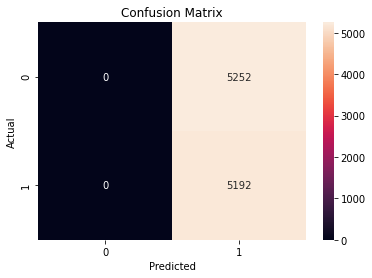

              precision    recall  f1-score   support

    SUPPORTS       0.00      0.00      0.00      5252
     REFUTES       0.50      1.00      0.66      5192

    accuracy                           0.50     10444
   macro avg       0.25      0.50      0.33     10444
weighted avg       0.25      0.50      0.33     10444



c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [16]:
results = evaluation(y_dev,y_pred_class)

In [17]:
print('Accuracy value: ',results[0])
conf_matrix = results[1]

Accuracy value:  0.49712753734201454


In [18]:
conf_matrix

array([[   0, 5252],
       [   0, 5192]], dtype=int64)

**For the chosen classifier, get predictions for the official test set associated to the best hyperparameter configuration.**

In [22]:
test_df = pd.read_csv('emb_test.csv',nrows=100)

In [23]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

In [25]:
# load the trained model from disk
knn = pickle.load(open('KNN.sav', 'rb'))
# get predictions for the official test set 
pred_test = knn.predict(x_test)

In [27]:
pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [175]:
with open('emb_test.csv', 'r') as read_obj:
    # pass the file object to DictReader() to get the DictReader object
    dict_reader = DictReader(read_obj)
    # get a list of dictionaries from dict_reader
    json_test = list(dict_reader)

    #delete the useless fields    
for i in range(len(json_test)):
    del json_test[i]['claim_embedding'], json_test[i]['input']

In [180]:
for index in range(len(json_test)):
    for i in range(len(pred_test)): #questo if quando viene girato su tutto il dataset non dovrebbe servire
        if pred_test[i]==1:
            json_test[index]['answer']= {'label':'SUPPORT'}
        else:
            json_test[index]['answer']= {'label':'REFUTES'}

**Put the predictions in a file named “test_set_pred_1.jsonl”**

In [185]:
# save the prediction into a file
with jsonlines.open('test_set_pred.jsonl', mode = 'w') as writer:
    writer.write(json_test)

-----------------------------------------------------------------------------------------

# SVM Classifier
--------------------------------------------------------------------------------------

### Tuning on the dev set
Function for tuning the hyperparameters. It returns the best params to use for the SVM

In [11]:
''' Method for tuning the hyperparameters
  Input: splitted dev set into x and y for the fit of the RandomizedSearchCV
  Output: best params to use for the SVM
'''
def tuning(x_dev,y_dev):
    # define the parameter values that should be searched
    C_range= list(np.arange(1,5,0.5))
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    gamma = ['auto', 'scale']
    probability = [True,False] # different types of distances (manhattan, euclidean, minkowksi)
    decision_function_shape= ['ovo', 'ovr']
    random_state_range=list(range(2,42,10))
    
    # save the "parameter grid"
    param_grid = dict(C=C_range,kernel=kernel, gamma=gamma,\
                      decision_function_shape=decision_function_shape,\
                      random_state=random_state_range,probability=probability)
    
    print('Params grid: ',param_grid) #need this for the report

    #define the classification model chosen
    model = svm.SVC()
    rand = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=5, n_jobs=-1)
    rand.fit(x_dev, y_dev)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    #save the optimize parameters
    best_param = rand.best_params_
    #return the tuning params for the model
    return best_param 

#### Now using the best parameter obtained by the tuning with the RandomizedSearchCV, we can train the train_set with the SVM

In [12]:
params = tuning(x_dev,y_dev) #dict of best parameters for the classifier

Params grid:  {'C': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['auto', 'scale'], 'decision_function_shape': ['ovo', 'ovr'], 'random_state': [2, 12, 22, 32], 'probability': [True, False]}
Rand. Best Score:  0.5028724627633527


In [13]:
params

{'random_state': 32,
 'probability': True,
 'kernel': 'linear',
 'gamma': 'scale',
 'decision_function_shape': 'ovr',
 'C': 4.0}

TRAIN THE MODEL AND SAVE IT

In [14]:
''' Method for training the model using the KNeighborsClassifier() as binary classifier. After the training, the model is saved into a pickle file
  Input: dictionary of the tuned parameters, train set splitted in feature and target (x_train, y_train)
'''
def classifier(params, x_train, y_train):
    #train the model using the optimized params obtained in the tuning
    SVM = svm.SVC(C=params['C'],gamma=params['gamma'],decision_function_shape=params['decision_function_shape'],\
                 kernel=params['kernel'],probability=params['probability'],random_state=params['random_state'])
    
    #fit the model
    SVM.fit(x_train, y_train)
    
    # save the model to disk
    filename = 'SVM.sav'
    pickle.dump(SVM, open(filename, 'wb'))

In [15]:
classifier(params, x_train, y_train)

MAKE CLASS PREDICTION ON  THE SAVED MODEL 

In [16]:
# load the trained model from disk
SVM = pickle.load(open('SVM.sav', 'rb'))

In [17]:
# make class predictions for the dev set, we need this to evaluate the model
y_pred_class = SVM.predict(x_dev)

EVALUATE THE MODEL

In [18]:
''' Function for the evaluation of the model. Using the metrics function from the library sklearn, here we compute the accuracy_score, the confusion_matrix and the precision and recall of the targets 'SUPPORTS', 'REFUTES'.
  Input: y_dev, predicted class
  Output: accuracy score,confusion matrix,precision score,recall score
'''
def evaluation(y_dev,y_pred_class):    
    # compute the accuracy 
    accuracy = metrics.accuracy_score(y_dev, y_pred_class)
    
    #build the confusion matrix and plot it
    confusion = metrics.confusion_matrix(y_dev, y_pred_class)
                #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # compute the precision and the recall on the label and print them
    target_names = ['SUPPORTS', 'REFUTES']
    print(metrics.classification_report(y_dev, y_pred_class, target_names=target_names))
    
    return accuracy,confusion

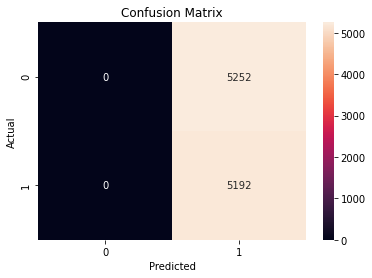

              precision    recall  f1-score   support

    SUPPORTS       0.00      0.00      0.00      5252
     REFUTES       0.50      1.00      0.66      5192

    accuracy                           0.50     10444
   macro avg       0.25      0.50      0.33     10444
weighted avg       0.25      0.50      0.33     10444



c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [19]:
results = evaluation(y_dev,y_pred_class)

In [20]:
print('Accuracy value: ',results[0])
conf_matrix = results[1]

Accuracy value:  0.49712753734201454


In [21]:
conf_matrix

array([[   0, 5252],
       [   0, 5192]], dtype=int64)

**For the chosen classifier, get predictions for the official test set associated to the best hyperparameter configuration.**

In [22]:
test_df = pd.read_csv('emb_test.csv',nrows=100)

In [23]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

In [25]:
# load the trained model from disk
SVM = pickle.load(open('SVM.sav', 'rb'))
# get predictions for the official test set 
pred_test = SVM.predict(x_test)

In [27]:
pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [175]:
with open('emb_test.csv', 'r') as read_obj:
    # pass the file object to DictReader() to get the DictReader object
    dict_reader = DictReader(read_obj)
    # get a list of dictionaries from dict_reader
    json_test = list(dict_reader)

    #delete the useless fields    
for i in range(len(json_test)):
    del json_test[i]['claim_embedding'], json_test[i]['input']

In [180]:
for index in range(len(json_test)):
    for i in range(len(pred_test)): #questo if quando viene girato su tutto il dataset non dovrebbe servire
        if pred_test[i]==1:
            json_test[index]['answer']= {'label':'SUPPORT'}
        else:
            json_test[index]['answer']= {'label':'REFUTES'}

**Put the predictions in a file named “test_set_pred_1.jsonl”**

In [185]:
# save the prediction into a file
with jsonlines.open('test_set_pred.jsonl', mode = 'w') as writer:
    writer.write(json_test)